This assignment will give you a real (active) research topic that I've discussed a little bit in class: predicting carbon storage as a function of high-resolution gridded data. In the class google drive you will find all the data you need in the Soyo_tile folder.

This assignment will have you use the automated variable selection approach within LASSO to deal with a common situation in regressions on raster-stacks: we have so much data everything is significant but will lead to massive overfitting. The basic approach used here will involve reading in 2d rasters, flattening them into a 1d column ready to add to a dataframe shaped object, which we will use as our X matrix.

Please turn in the completed Notebook (.ipynb) file that includes the results you generate. 

Below is some starter code along with specific assignment questions.


In [13]:
# Load libraries
import numpy as np
import os
from osgeo import gdal
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
import statsmodels
from statsmodels.api import OLS
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score



## Step 1: Download the data and set paths

Download the latest data from the class's google drive. In there, you will need the the files in `Data/python_assignment_2` data and assign a relative path to the `soyo_tile` directory in that assignment directory. It is your task to ensure your script runs in the right location and the data is stored in the right location that this relative path works.

In [14]:
# Step 1 code
#define the data relative path
import os, random
data_dir = '../../../../data/soyo_tile' 

## Step 2: Set raster paths 

Assign each of the raster paths in the directory to a dictionary for later use. I've included most of the code (so you don't have to waste your time typing), but add in the missing paths.

In [15]:
# Step 2 code

raster_paths = {}

# First is the dependent varable, Above Ground Carbon (AGB) in tons, measured 
# at 30 meters globally (here it is clipped to a smaller area)
raster_paths['agb_observed_baccini_2000_30m'] = os.path.join(data_dir, "agb_observed_baccini_2000_30m.tif")

# Here are some of the independent variables
raster_paths['CRFVOL_M_sl1_250m'] = os.path.join(data_dir, "CRFVOL_M_sl1_250m.tif")
raster_paths['HISTPR_250m'] = os.path.join(data_dir, "HISTPR_250m.tif")
raster_paths['OCDENS_M_sl1_250m'] = os.path.join(data_dir, "OCDENS_M_sl1_250m.tif")
raster_paths['PHIHOX_M_sl1_250m'] = os.path.join(data_dir, "PHIHOX_M_sl1_250m.tif")
raster_paths['roughness_30s'] = os.path.join(data_dir, "roughness_30s.tif")
raster_paths['SLGWRB_250m'] = os.path.join(data_dir, "SLGWRB_250m.tif")
raster_paths['SLTPPT_M_sl1_250m'] = os.path.join(data_dir, "SLTPPT_M_sl1_250m.tif")
raster_paths['terrain_ruggedness_index_30s'] = os.path.join(data_dir, "terrain_ruggedness_index_30s.tif")
raster_paths['TEXMHT_M_sl1_250m'] = os.path.join(data_dir, "TEXMHT_M_sl1_250m.tif")
raster_paths['wc2.0_bio_30s_01'] = os.path.join(data_dir, "wc2.0_bio_30s_01.tif")
raster_paths['alt_30s'] = os.path.join(data_dir, "alt_30s.tif")
raster_paths['AWCh1_M_sl1_250m'] = os.path.join(data_dir, "AWCh1_M_sl1_250m.tif")
raster_paths['BDRICM_M_250m'] = os.path.join(data_dir, "BDRICM_M_250m.tif")
raster_paths['BDRLOG_M_250m'] = os.path.join(data_dir, "BDRLOG_M_250m.tif")
raster_paths['BLDFIE_M_sl1_250m'] = os.path.join(data_dir, "BLDFIE_M_sl1_250m.tif")


In [16]:
print(raster_paths.keys())

dict_keys(['agb_observed_baccini_2000_30m', 'CRFVOL_M_sl1_250m', 'HISTPR_250m', 'OCDENS_M_sl1_250m', 'PHIHOX_M_sl1_250m', 'roughness_30s', 'SLGWRB_250m', 'SLTPPT_M_sl1_250m', 'terrain_ruggedness_index_30s', 'TEXMHT_M_sl1_250m', 'wc2.0_bio_30s_01', 'alt_30s', 'AWCh1_M_sl1_250m', 'BDRICM_M_250m', 'BDRLOG_M_250m', 'BLDFIE_M_sl1_250m'])


## Step 3: Open the rasters

Our dependent variable will be 30 meter observations of carbon storage from Baccini et al. (unpublished, but soon to be published) data. The label I assigned in the dictionary above was agb_observed_baccini_2000_30m for this variable. Use gdal.Open, GetRasterBand(1) and ReadAsArray() to read this geotiff as a numpy file

Side note: If you get an error like: "ERROR 4: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff." make sure you have installed gdal with the mamba method from lecture 1. 

In [17]:
# Step 3 code
#here we use the function load_array to load raster into a numpy array.
def load_array(input_raster_path):
    """Load a raster into a numpy array"""
    raster = gdal.Open(input_raster_path)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

#load the dependent variable as numpy array
array = raster_paths['agb_observed_baccini_2000_30m']
agb_observed = load_array(array)
print("Shape of dependent variable:",agb_observed.shape)


Shape of dependent variable: (2000, 2000)


## Step 4: Define some arrays

Create an empty numpy array (or full of zeros) of the right shape to house all our raster data. A very CPU-efficient way of arranging a stack of 2d rasters (which would be 3d once stacked up), is to flatten each 2d raster into a longer 1d array. This will go into our X matrix. In order to create the right sized X matrix, first get the n_obs and n_vars by inspecting the dependent variable raster and the dictionary of inputs above. Note that the n_vars should be the number of independent AND dependent variables.

In [19]:
# Step 4 code
# Get the shape of the dependent variable raster
n_obs = agb_observed.shape[0] * agb_observed.shape[1]  

# Count the number of variables (including dependent variable)
n_vars = len(raster_paths)
print(n_vars)

# Create an empty array filled with zeros
data_array = np.zeros((n_obs, n_vars))
print("Shape:",data_array.shape)

16
Shape: (4000000, 16)


## Step 5: Load all the independent variables

- Iterate through the dictionary and load each raster as a 2d array
- flatten it to 1d using the .flatten() method in numpy
- Assign this 1d array to the correct column of the data array. By convention, the depvar will be the first column.

Hint, assuming you have arranged your X array in the correct way, it should have observations (pixels) as rows and variables as cols. Given that each flattened array is for one variable and is as long as there are rows, a convenient way of assigning it would be to use numpy slice notation, potentially similar to:

`data_array[:, column_index_integer]`

The first colon just denotes the whole row and the column index is an integer you could create pointing to the right row.

Some incomplete code to get you started is below.

In [ ]:
# Step 5 code
feature_names = []

for col_index, (name, path) in enumerate(raster_paths.items()):
    print('Loading', path)
    raster_array = load_array(path)  # Load raster data
    flattened_raster_array = raster_array.flatten()  # Flatten into a 1D array
    data_array[:, col_index] = flattened_raster_array  # Assign to the correct column
    feature_names.append(name)  # Store feature names

print(feature_names)
print(data_array.shape)

Loading ../../../../data/soyo_tile/agb_observed_baccini_2000_30m.tif
Loading ../../../../data/soyo_tile/CRFVOL_M_sl1_250m.tif


Loading ../../../../data/soyo_tile/HISTPR_250m.tif
Loading ../../../../data/soyo_tile/OCDENS_M_sl1_250m.tif
Loading ../../../../data/soyo_tile/PHIHOX_M_sl1_250m.tif
Loading ../../../../data/soyo_tile/roughness_30s.tif
Loading ../../../../data/soyo_tile/SLGWRB_250m.tif
Loading ../../../../data/soyo_tile/SLTPPT_M_sl1_250m.tif
Loading ../../../../data/soyo_tile/terrain_ruggedness_index_30s.tif
Loading ../../../../data/soyo_tile/TEXMHT_M_sl1_250m.tif
Loading ../../../../data/soyo_tile/wc2.0_bio_30s_01.tif
Loading ../../../../data/soyo_tile/alt_30s.tif
Loading ../../../../data/soyo_tile/AWCh1_M_sl1_250m.tif
Loading ../../../../data/soyo_tile/BDRICM_M_250m.tif
Loading ../../../../data/soyo_tile/BDRLOG_M_250m.tif
Loading ../../../../data/soyo_tile/BLDFIE_M_sl1_250m.tif
['agb_observed_baccini_2000_30m', 'CRFVOL_M_sl1_250m', 'HISTPR_250m', 'OCDENS_M_sl1_250m', 'PHIHOX_M_sl1_250m', 'roughness_30s', 'SLGWRB_250m', 'SLTPPT_M_sl1_250m', 'terrain_ruggedness_index_30s', 'TEXMHT_M_sl1_250m', 'wc2.0_bi

# Step 6: 

Extract the first array row of the data_array and assign it to y. Assign the rest to X.

In [ ]:
# Step 6 code

# Extracting y (our dependent variable)

y = data_array[:, 0]  
print(y.shape)

# Extracting X (our independent variables)
X = data_array[: ,1:]  
print(X.shape)



(4000000,)
(4000000, 15)


# Step 7:

Split the X and y into testing and training data such that the training data is the first million pixels and the testing data is the next 200,000. Do this using numpy slice notation on the X and y variables you created.

In [ ]:
# Step 7 code
# Splitting X and y into training and testing sets using NumPy slice notation
X_train = X[:1000000]
X_test = X[-200000:]
y_train = y[:1000000]
y_test = y[-200000:]

# Step 8 (optional but useful):

To make the code run faster, we are going to use every 10th pixel. We can easily get this via numpy slicing again, using x_train[::10] to get every 10th pixel.

In [ ]:
# Step 8 code
X_train = X_train[::10]
y_train = y_train[::10]
X_test = X_test[::10]
y_test = y_test[::10]

# Step 9:

Create a Lasso object (using the default penalty term alpha) and fit it to the training data. Create and print out a vector of predicted carbon values. Also print out the score using the lasso object's .score() method on the TESTING data. Print out the fitted lasso score.

In [ ]:
# Step 9 code
# Create an empty Lasso object with a few initial parameters set
model_lasso = Lasso(alpha=1.0, random_state=0, max_iter=10000)
y_train_hat_lasso = model_lasso.fit(X_train, y_train)
print(model_lasso)


Lasso(max_iter=10000, random_state=0)


In [ ]:
y_train_hat_lasso = model_lasso.predict(X_train)
print('Predicted carbon values:', y_train_hat_lasso)

Predicted carbon values: [66.6869377  64.74660367 69.07640951 ... 90.60592619 89.33928596
 74.39677148]


In [ ]:
score= model_lasso.score(X_train, y_train)
print("Accuracy on train set:", score)

Accuracy on train set: 0.5943975260169662


In [ ]:
score = model_lasso.score(X_test, y_test)

print("Accuracy on test set:", score)

Accuracy on test set: 0.5097471522100042


# Step 10, optional and just for fun:.

To view how our projections LOOK, we can create a predicted matrix on the whole X, reshape it back into the original 2d shape and look at it. You can compare this to the input array to visualize how it looks. Note that this will only work if you name your objects like mine.

In [ ]:
# Step 10 code

# Step 11:

Create a list of 30 alphas using ` np.logspace(-1, 3, 30)`. 

Using a for loop iterate over those alphas and run the Lasso model like above, but using the alpha values in the loop. Print out the fit score at each step. Using matplotlib, plot how this value changes as alpha changes. Finally, extract the best alpha of the bunch. 

In [ ]:
#Step 11 code
#empty list to store the score
test_scores = {}
#list of 30 alphas
alphas = np.logspace(-1, 3, 30)

for alpha in alphas:
    model_lasso = Lasso(alpha=alpha, random_state=0, max_iter=10000)
    model_lasso.fit(X_train, y_train)
    score = model_lasso.score(X_test, y_test)
    test_scores[alpha] = score
    print('Alpha:', alpha, 'Score:', score)

best_alpha_test = max(test_scores, key=test_scores.get)
best_alpha = best_alpha_test
print('Best Alpha for Test Scores:', best_alpha_test)


Alpha: 0.1 Score: 0.49281221653744667
Alpha: 0.1373823795883263 Score: 0.49364982587428985
Alpha: 0.18873918221350972 Score: 0.4947816945001292
Alpha: 0.2592943797404667 Score: 0.4963006921708921
Alpha: 0.3562247890262442 Score: 0.4983197104806468
Alpha: 0.4893900918477494 Score: 0.5009660869267845
Alpha: 0.6723357536499337 Score: 0.5043613628715736
Alpha: 0.9236708571873861 Score: 0.5085721749191421
Alpha: 1.2689610031679222 Score: 0.5124513710336216
Alpha: 1.743328822199988 Score: 0.5154271242406102
Alpha: 2.395026619987486 Score: 0.5174592640326362
Alpha: 3.2903445623126677 Score: 0.5198426609470972
Alpha: 4.520353656360243 Score: 0.5201536562062508
Alpha: 6.2101694189156165 Score: 0.5167502877628407
Alpha: 8.531678524172806 Score: 0.5100852430540102
Alpha: 11.721022975334806 Score: 0.49358248366080293
Alpha: 16.102620275609393 Score: 0.4652163390026889
Alpha: 22.12216291070448 Score: 0.42348804392372696
Alpha: 30.39195382313198 Score: 0.3478559630012372
Alpha: 41.753189365604 Score

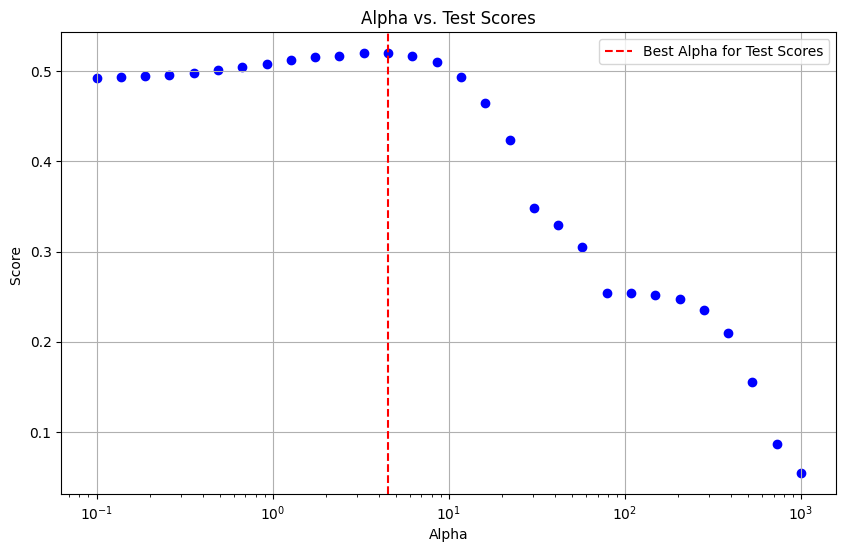

Best Alpha for Test Scores: 4.520353656360243


In [ ]:
# Here, I insert the code to make plot inside the loop. I did take some help
#to nicely label the plot.

test_scores = {}
alphas = np.logspace(-1, 3, 30)

best_alpha = None
best_alpha_test = None

plt.figure(figsize=(10, 6))

for alpha in alphas:
    model_lasso = Lasso(alpha=alpha, random_state=0, max_iter=10000)
    model_lasso.fit(X_train, y_train)
    score = model_lasso.score(X_test, y_test)
    test_scores[alpha] = score
    
    # Find best alpha for test scores
    if best_alpha_test is None or score > test_scores[best_alpha_test]:
        best_alpha_test = alpha

    plt.scatter(alpha, score, color='blue')

# Plotting
plt.axvline(best_alpha_test, linestyle='--', color='red', 
            label='Best Alpha for Test Scores')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Score ')
plt.title('Alpha vs. Test Scores')
plt.legend()
plt.grid(True)
plt.show()

print('Best Alpha for Test Scores:', best_alpha_test)


# Step 12: 

Rerun the lasso with that best value and identify all of the coefficiencts that were "selected" ie had non-zero values. Save these coefficient indices and labels to a list.

In [ ]:
# Step 12 code

#reruning the same steps as above with best alpha that we identified above
lasso_2 = Lasso(alpha = 4.520353656360243, random_state = 0, max_iter = 10000).fit(X_train, y_train)

print("Coefficients:", lasso_2.coef_)

Coefficients: [ 0.          0.63974061  0.24462421 -6.22075713 -0.         -0.
 -0.          0.32890017 -5.36312292  0.         -0.07871124 -0.
  4.34081434  1.14100755 -0.32220005]


In [ ]:
#A thing to realize is that the features_name list we created in Step 5 include 
#"agb_observed_baccini_2000_30m" (our dependent variable) as the first element,
# so we create a new list of independent variables only

print(feature_names)
feature_name = feature_names[1:]
print(feature_name)

['agb_observed_baccini_2000_30m', 'CRFVOL_M_sl1_250m', 'HISTPR_250m', 'OCDENS_M_sl1_250m', 'PHIHOX_M_sl1_250m', 'roughness_30s', 'SLGWRB_250m', 'SLTPPT_M_sl1_250m', 'terrain_ruggedness_index_30s', 'TEXMHT_M_sl1_250m', 'wc2.0_bio_30s_01', 'alt_30s', 'AWCh1_M_sl1_250m', 'BDRICM_M_250m', 'BDRLOG_M_250m', 'BLDFIE_M_sl1_250m']
['CRFVOL_M_sl1_250m', 'HISTPR_250m', 'OCDENS_M_sl1_250m', 'PHIHOX_M_sl1_250m', 'roughness_30s', 'SLGWRB_250m', 'SLTPPT_M_sl1_250m', 'terrain_ruggedness_index_30s', 'TEXMHT_M_sl1_250m', 'wc2.0_bio_30s_01', 'alt_30s', 'AWCh1_M_sl1_250m', 'BDRICM_M_250m', 'BDRLOG_M_250m', 'BLDFIE_M_sl1_250m']


In [ ]:
#now we identify the selected coefficients among the 15 independent variables

selected_coefficient_labels = []
selected_coefficient_indices = []
for i in range(len(lasso_2.coef_)):
    print('Coefficient', feature_name[i], 'was', lasso_2.coef_[i])
    if abs(lasso_2.coef_[i]) > 0:
        selected_coefficient_labels.append(feature_name[i])
        selected_coefficient_indices.append(i)

Coefficient CRFVOL_M_sl1_250m was 0.0
Coefficient HISTPR_250m was 0.6397406121398291
Coefficient OCDENS_M_sl1_250m was 0.24462421409903706
Coefficient PHIHOX_M_sl1_250m was -6.220757126363239
Coefficient roughness_30s was -0.0
Coefficient SLGWRB_250m was -0.0
Coefficient SLTPPT_M_sl1_250m was -0.0
Coefficient terrain_ruggedness_index_30s was 0.32890016787035947
Coefficient TEXMHT_M_sl1_250m was -5.3631229245726155
Coefficient wc2.0_bio_30s_01 was 0.0
Coefficient alt_30s was -0.07871124274874718
Coefficient AWCh1_M_sl1_250m was -0.0
Coefficient BDRICM_M_250m was 4.340814344592574
Coefficient BDRLOG_M_250m was 1.1410075474188568
Coefficient BLDFIE_M_sl1_250m was -0.3222000466550357


In [ ]:
#following this we get the list of our selected coefficients
print('selected_coefficient_labels', selected_coefficient_labels)

selected_coefficient_labels ['HISTPR_250m', 'OCDENS_M_sl1_250m', 'PHIHOX_M_sl1_250m', 'terrain_ruggedness_index_30s', 'TEXMHT_M_sl1_250m', 'alt_30s', 'BDRICM_M_250m', 'BDRLOG_M_250m', 'BLDFIE_M_sl1_250m']


# Step 13:

Using Statsmodels, run an OLS version on the selected variables.

Use print to show the results table.

Write a description of any advantages this approach has over vanilla OLS.


In [ ]:
#prepare our X and y variable for OLS 
X_train_selected = X_train[:, selected_coefficient_indices]
print(X_train_selected.shape)
print(y_train.shape)

(100000, 9)
(100000,)


In [ ]:
#run the regression
import statsmodels
from statsmodels.api import OLS

# Add a constant term 
X_with_constant = statsmodels.api.add_constant(X_train_selected)
#store the result and print it
result = OLS(y_train, X_with_constant).fit().summary()
print(result)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                 1.612e+04
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:51:32   Log-Likelihood:            -5.1551e+05
No. Observations:              100000   AIC:                         1.031e+06
Df Residuals:                   99990   BIC:                         1.031e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2923      1.332      0.970      0.3

The obvious advantage of this approach over vanilla OLS is that we get to use only those coefficients 
that have an impact on the dependent variable (y), naturally improving the model efficieny.